### Second Notebook: Data Cleaning & Preprocessing (Sprint 1 - Continued)

In [1]:
# Imports and Setup
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

data_path = os.path.join(os.getcwd(), '..', 'data')
out_path = os.path.join(os.getcwd(), '..', 'outputs')     # For the output

# Read the files
train = pd.read_csv(os.path.join(data_path, 'train.csv'))
test = pd.read_csv(os.path.join(data_path, 'test.csv'))
labels = pd.read_csv(os.path.join(data_path, 'train_labels.csv'))

# Merge training labels
df = pd.merge(train, labels, on='id')
print('Files successfully loaded and merged!')


Files successfully loaded and merged!


### ---------------------------------------------
### 🚧 Step 1: Handle Missing & Invalid Values
### ---------------------------------------------

In [2]:
# Replace 0s with NaN where 0 means "missing" or invalid

df['construction_year'] = df['construction_year'].replace(0, np.nan)
df['gps_height'] = df['gps_height'].replace([0, -90], np.nan)
df['longitude'] = df['longitude'].replace(0, np.nan)
print("Missing values after cleaning invalid numeric entries:")
print(df[['construction_year', 'gps_height', 'longitude']].isnull().sum())
missing_before = df['construction_year'].isna().sum()
# Save original missing count

print("Missing construction_year before:", missing_before)

Missing values after cleaning invalid numeric entries:
construction_year    20709
gps_height           20439
longitude             1812
dtype: int64
Missing construction_year before: 20709


### ---------------------------------------------
### 🔧 Step 2: Construction Year Imputation
### ---------------------------------------------

In [3]:
# Save original missing count

print("Missing before:", missing_before)
# Pumps in the same region likely have similar construction years
# Same funder or installer may follow same timeline
# Fill missing years with the median by region + installer
# If construction_year is missing, we could use date_recorded.year as an upper bound for imputation.
df['date_recorded'] = pd.to_datetime(df['date_recorded'])
df['recorded_year'] = df['date_recorded'].dt.year



Missing before: 20709


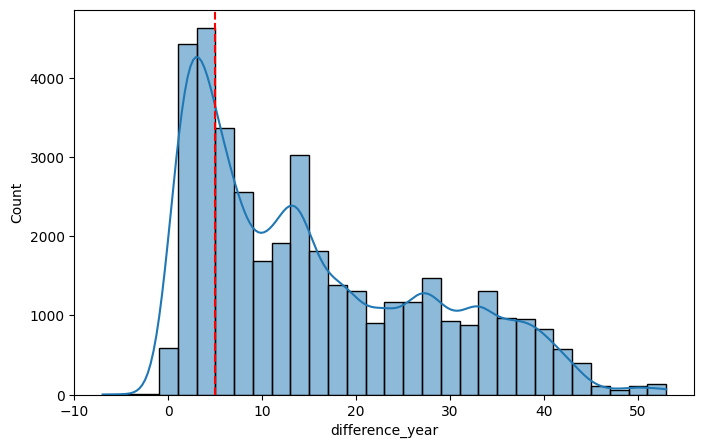

In [4]:
#visualize the relationship between construction_year and date_recorded to see how they are related
valid_years = df[df['construction_year'].notna()].copy()
valid_years['difference_year'] = valid_years['recorded_year']-valid_years['construction_year']

plt.figure(figsize=(8, 5))
sns.histplot(valid_years['difference_year'], bins=30, kde=True)
plt.axvline(5, color='red', linestyle='--', label='5-Year Gap')
plt.show()


In [5]:
#Impute using region + installer
df['construction_year'] = df.groupby(['region', 'installer'])['construction_year'].transform(
    lambda x: x.fillna(x.median())
)
#Impute using region only (for rows still missing)
df['construction_year'] = df.groupby('region')['construction_year'].transform(
    lambda x: x.fillna(x.median())
)
#Use recorded year - 5
df['construction_year'] = df['construction_year'].fillna(df['recorded_year'] - 5)
missing_after = df['construction_year'].isna().sum()
print("Missing after_construction_year:", missing_after)
filled_count = missing_before - missing_after
print("Filled_construction_year:", filled_count)
df.to_csv(os.path.join(data_path, "cleaned_data_filled.csv"), index=False)
print(df['longitude'].describe())
print("lMissing values in latitude and longitude:",df[['latitude', 'longitude']].isnull().sum())


Missing after_construction_year: 0
Filled_construction_year: 20709
count    57588.000000
mean        35.149669
std          2.607428
min         29.607122
25%         33.285100
50%         35.005943
75%         37.233712
max         40.345193
Name: longitude, dtype: float64
lMissing values in latitude and longitude: latitude        0
longitude    1812
dtype: int64


### ---------------------------------------------
### 🌍 Step 3: Fill Coordinates and Elevation
### ---------------------------------------------

In [6]:
# Handle GPS coordinates
print(df['longitude'].describe())
print("latitudeb and longitude missing value before:", df[['latitude', 'longitude']].isnull().sum())

# Convert to numeric in case of weird types
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

# Drop invalid latitudes: outside Tanzania range or near zero
df['latitude'] = df['latitude'].apply(lambda x: np.nan if pd.isna(x) or abs(x) < 0.1 or x < -15 or x > 0 else x)
df['longitude'] = df['longitude'].apply(lambda x: np.nan if pd.isna(x) or abs(x) < 10 or x < 29 or x > 42 else x)

# Drop rows where lat/lon still missing
df = df.dropna(subset=['latitude', 'longitude'])
print("Remaining rows after dropping invalid GPS data:", len(df))

# Save updated version
df.to_csv(os.path.join(data_path,"cleaned_data_filled_V2.csv"), index=False)
print("Cleaned data saved to data/cleaned_data_filled_V2.csv")



count    57588.000000
mean        35.149669
std          2.607428
min         29.607122
25%         33.285100
50%         35.005943
75%         37.233712
max         40.345193
Name: longitude, dtype: float64
latitudeb and longitude missing value before: latitude        0
longitude    1812
dtype: int64
Remaining rows after dropping invalid GPS data: 57588
Cleaned data saved to data/cleaned_data_filled_V2.csv


In [7]:
## filling missing values for gps_height
# # Replace invalid gps_height values (e.g. 0 or negative)
df['gps_height'] = df['gps_height'].apply(lambda x: np.nan if x <= 0 else x)

missing_gps_before = df['gps_height'].isna().sum()
print("Missing before gps_height:", missing_gps_before)

# Fill using median per basin
df['gps_height'] = df.groupby('basin')['gps_height'].transform(
    lambda x: x.fillna(x.median())
)
# Fill any still missing using region median
df['gps_height'] = df.groupby('region')['gps_height'].transform(
    lambda x: x.fillna(x.median())
)    
missing_gps_after = df['gps_height'].isna().sum()
print("Missing after gps_height:", missing_gps_after)
print("Filled gps_height:", missing_gps_before - missing_gps_after)
df.to_csv(os.path.join(data_path, "cleaned_data_filled_V3.csv"), index=False)
print("Saved updated dataset to data/cleaned_data_filled_V3.csv")



Missing before gps_height: 20122
Missing after gps_height: 0
Filled gps_height: 20122
Saved updated dataset to data/cleaned_data_filled_V3.csv


### ---------------------------------------------
### 👥 Step 4: Population Cleaning
### ---------------------------------------------

Missing population before: 19569


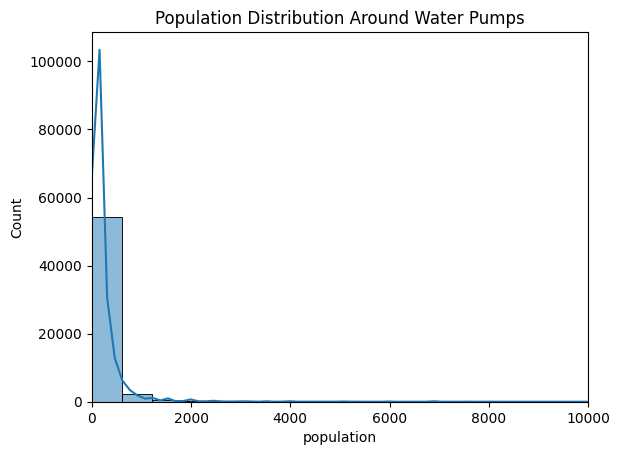

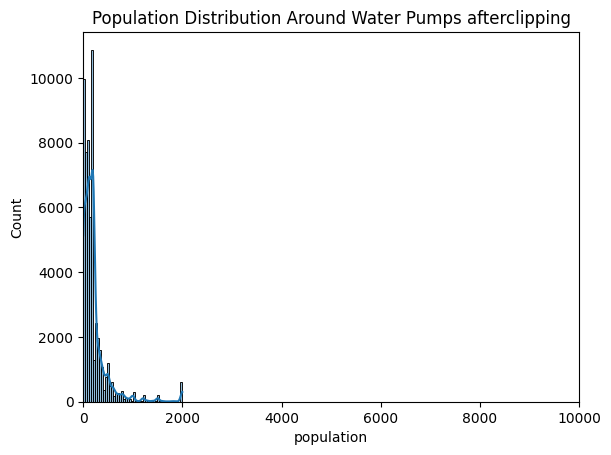

In [8]:
# filling population
# Replace 0 with NaN
df['population'] = df['population'].replace(0, np.nan)
missing_pop_before = df['population'].isna().sum()

print("Missing population before:", missing_pop_before)

# Fill using median by district_code
df['population'] = df.groupby('district_code')['population'].transform(
    lambda x: x.fillna(x.median())
)
# Fill any still missing with median by region
df['population'] = df.groupby('region')['population'].transform(
    lambda x: x.fillna(x.median())
)

df.to_csv(os.path.join(data_path, "cleaned_data_filled_V4.csv"), index=False)

sns.histplot(df['population'], bins=50, kde=True)
plt.xlim(0, 10000)  # Focus on lower range
plt.title("Population Distribution Around Water Pumps")
#plt.savefig("outputs/population_distribution_before_clipping.png", dpi=300, bbox_inches='tight')
plt.show()
df['population'] = df['population'].clip(upper=1999)
sns.histplot(df['population'], bins=50, kde=True)
plt.xlim(0, 10000)  # Focus on lower range
plt.title("Population Distribution Around Water Pumps afterclipping")
#plt.savefig("outputs/population_distribution_after_clipping.png", dpi=300, bbox_inches='tight')
df.to_csv(os.path.join(data_path, "cleaned_data_filled_V5.csv"))
plt.show()

### ---------------------------------------------
### Handelling Outliers
### ---------------------------------------------

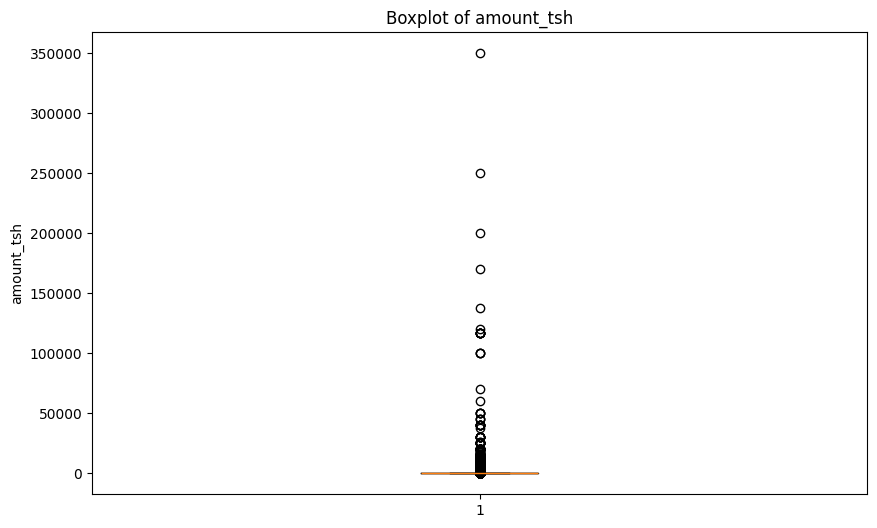

In [9]:
plt.figure(figsize=(10,6))
plt.boxplot(df['amount_tsh'])
plt.title('Boxplot of amount_tsh')
plt.ylabel('amount_tsh')
plt.show()

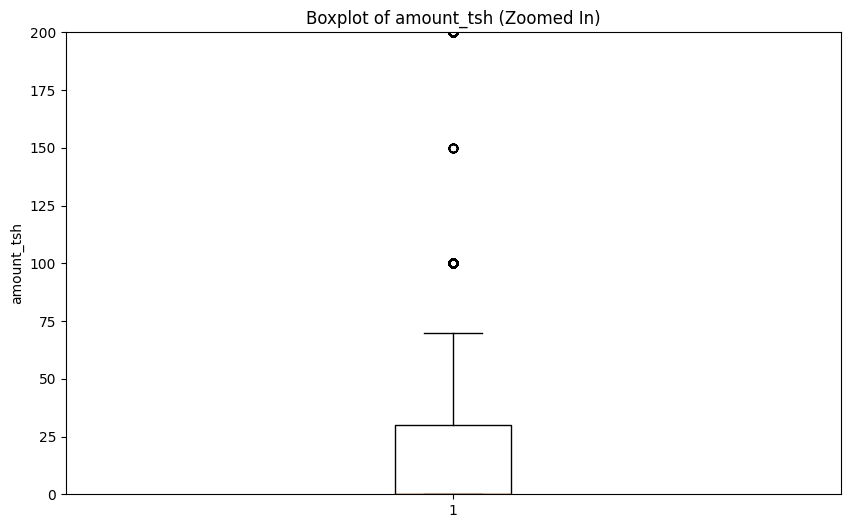

In [10]:
plt.figure(figsize=(10,6))
plt.boxplot(df['amount_tsh'].dropna())
plt.ylim(0, 200)  # Focus on the non-outlier range (up to 2,425 we calculated)
plt.title('Boxplot of amount_tsh (Zoomed In)')
plt.ylabel('amount_tsh')
plt.show()

### We want to check if amount_tsh is different for these status groups, This helps us see if amount_tsh is useful for predicting status.

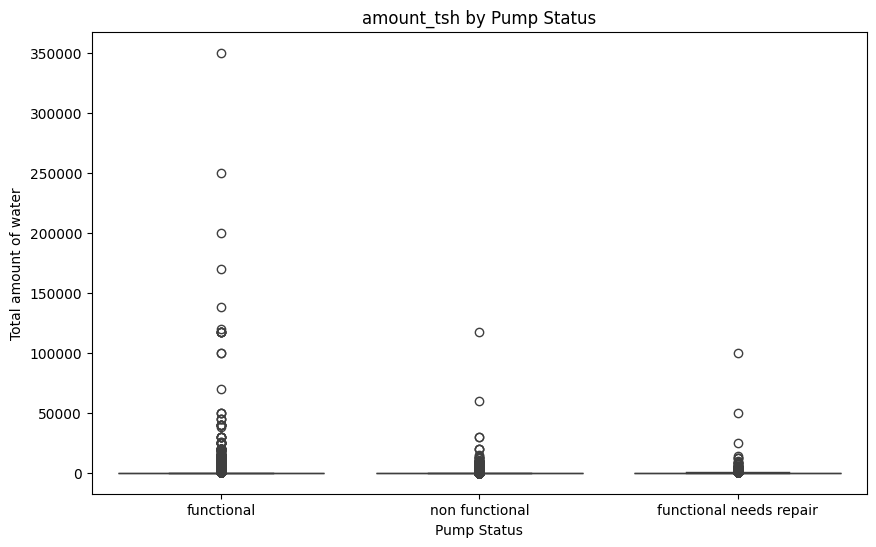

In [11]:
plt.figure(figsize=(10,6))
sns.boxplot(x='status_group', y='amount_tsh', data=df)

#plt.ylim(0,1500)
plt.title('amount_tsh by Pump Status')
plt.xlabel('Pump Status')
plt.ylabel('Total amount of water')
plt.show()

#### There are a lot of outliers (very big amount_tsh values) above 1500.
#### Those high values mostly belong to functional pumps.
#### So we cap the 'amount_tsh' at 150000.

In [12]:
#cap the 'amount_tsh' at 1500
df['amount_tsh_capped'] = df['amount_tsh'].apply(lambda x: min(x, 15000))

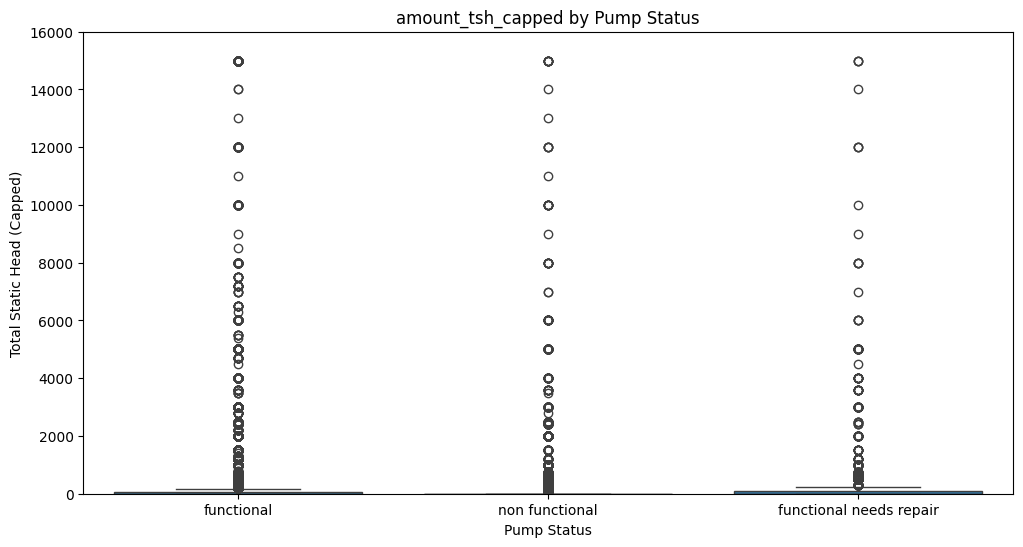

In [13]:
plt.figure(figsize=(12,6))
sns.boxplot(x='status_group', y='amount_tsh_capped', data=df)
plt.ylim(0, 16000)
plt.title('amount_tsh_capped by Pump Status')
plt.xlabel('Pump Status')
plt.ylabel('Total Static Head (Capped)')
plt.show()

In [14]:
df[df['status_group'] == 'non functional']['amount_tsh'].describe()

count     22268.000000
mean        126.564379
std        1123.721177
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      117000.000000
Name: amount_tsh, dtype: float64

#### Most of the non functional pumps have amount_tsh = 0 (confirmed). But there are a few very high values (like 117,000) in non functional.These could be errors (bad measurements),Or maybe something else is broken (e.g., mechanical damage, not water shortage).

In [15]:
df.to_csv(os.path.join(data_path, "cleaned_data_filled_V6.csv"), index=False)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['amount_tsh_scaled'] = scaler.fit_transform(df[['amount_tsh_capped']])



### ---------------------------------------------
### Encode Categorical Variables
### ---------------------------------------------

missing categorical values:
date_recorded                0
funder                    3624
installer                 3636
wpt_name                     2
basin                        0
subvillage                 371
region                       0
lga                          0
ward                         0
public_meeting            2976
recorded_by                  0
scheme_management         3751
scheme_name              27336
permit                    3056
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
quantity_group               0
source                       0
source_type                  0
source_class                 0
waterpoint_type              0
waterpoint_type_group        0
status_group                 0
dtype: int6

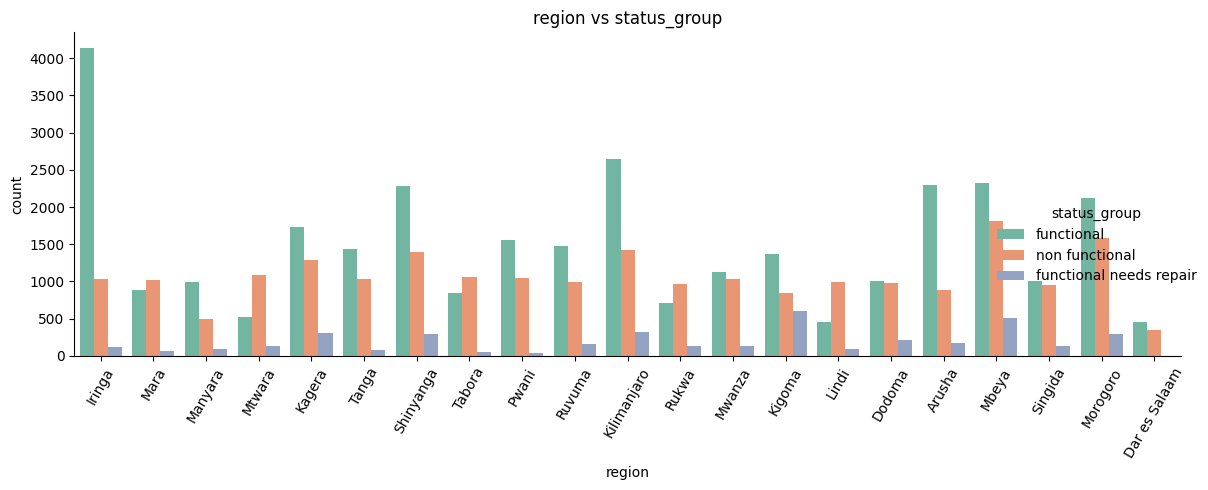

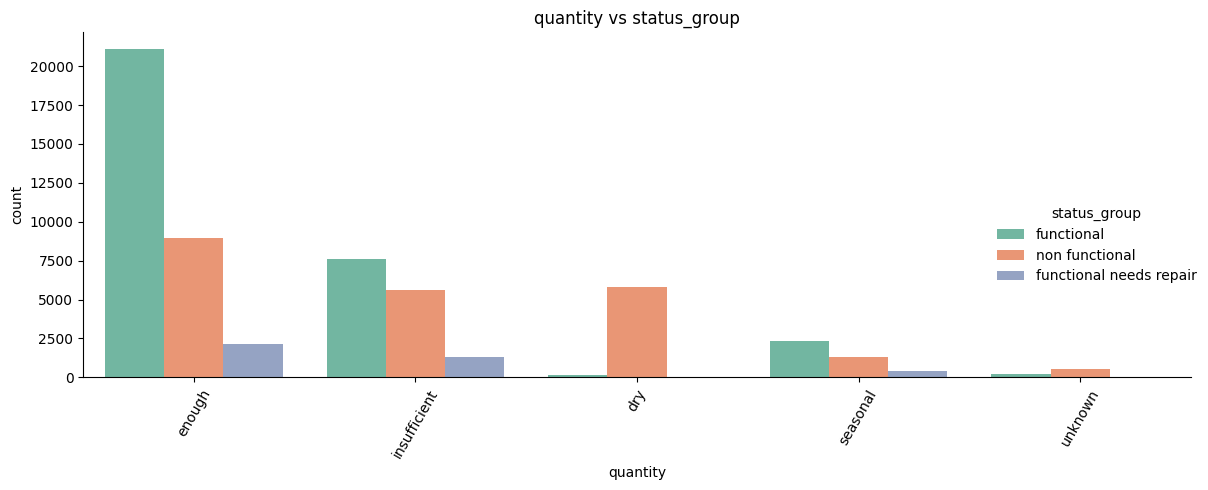

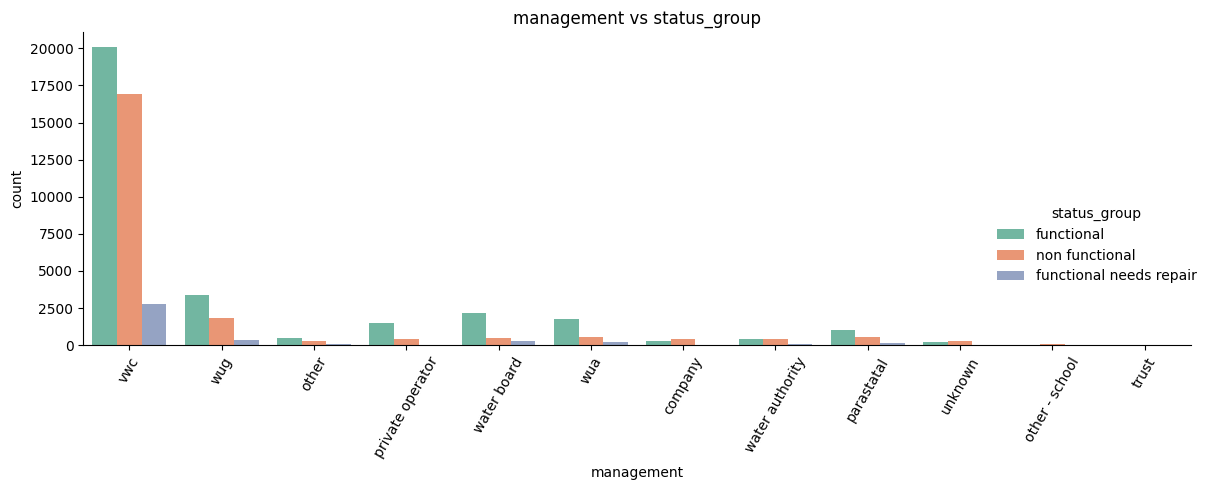

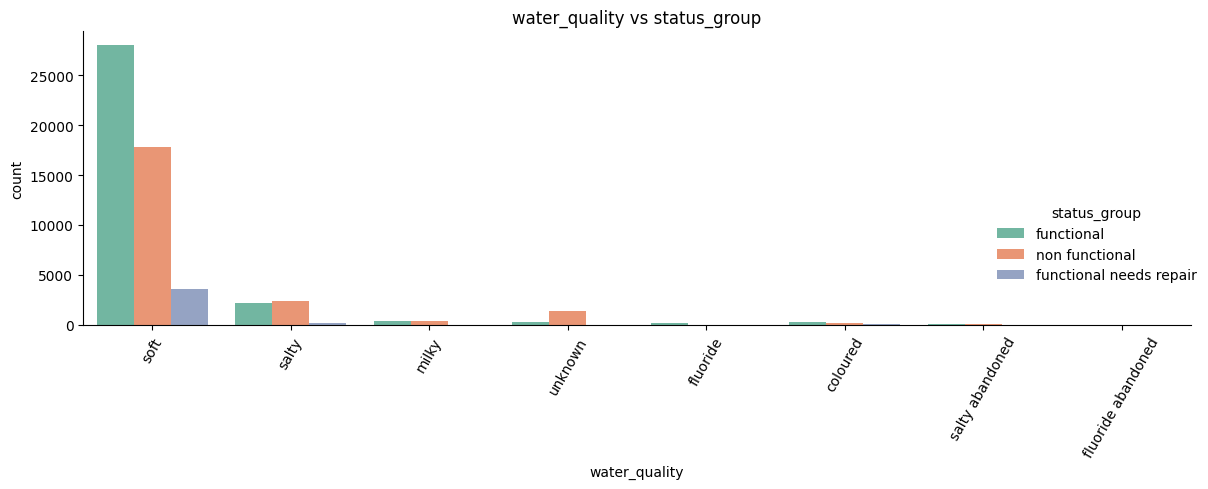

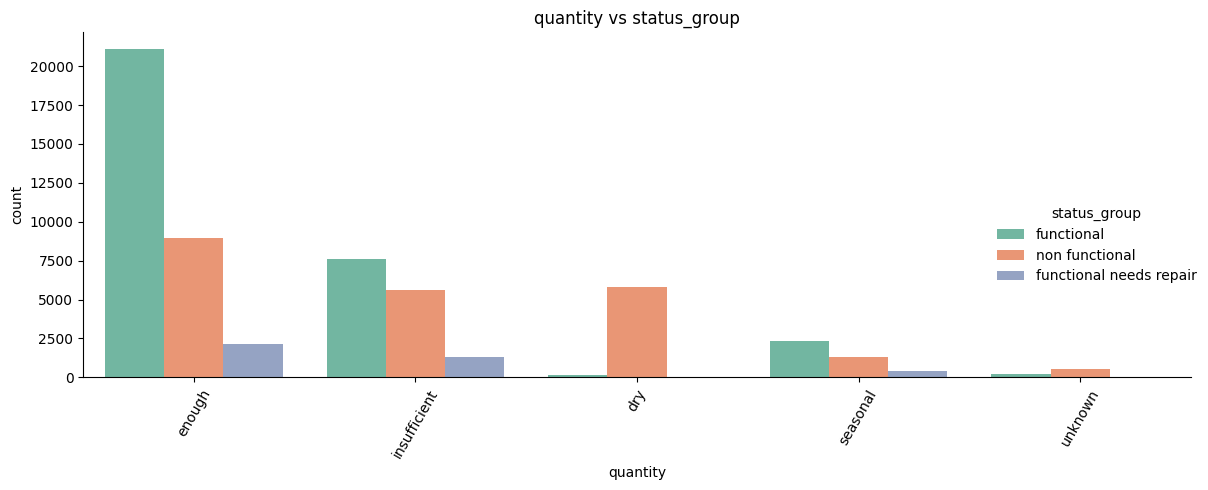

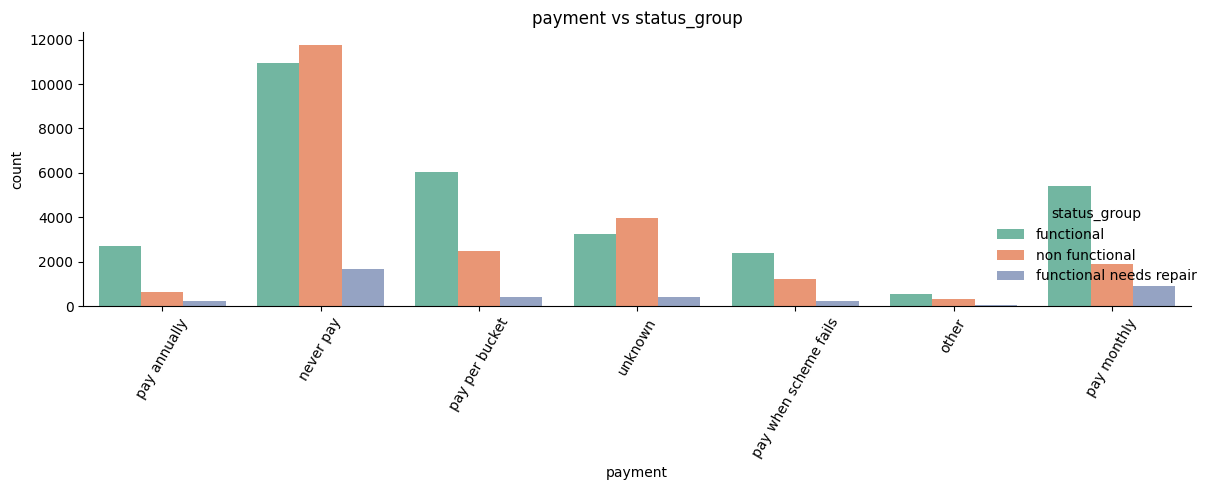

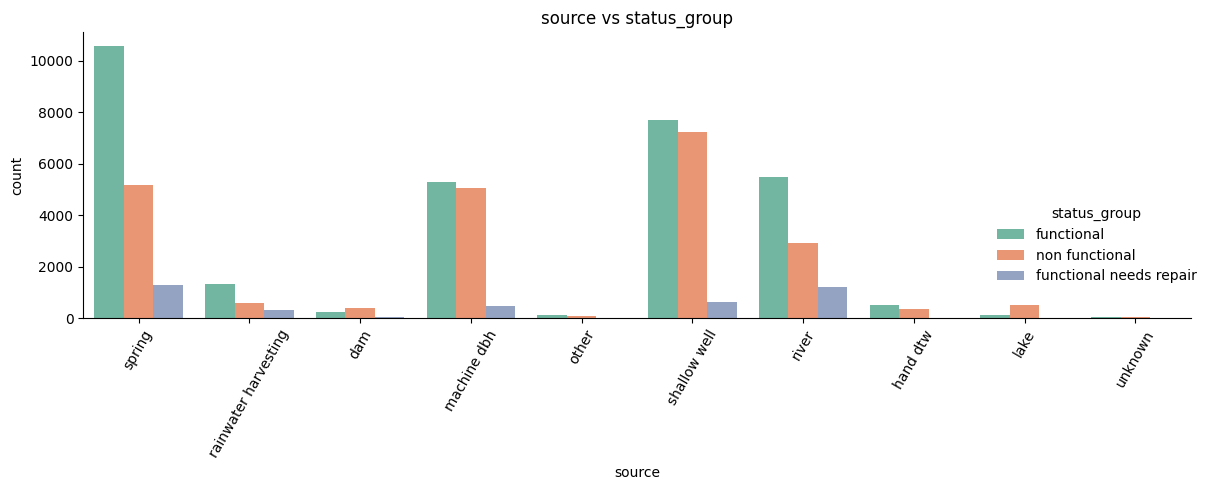

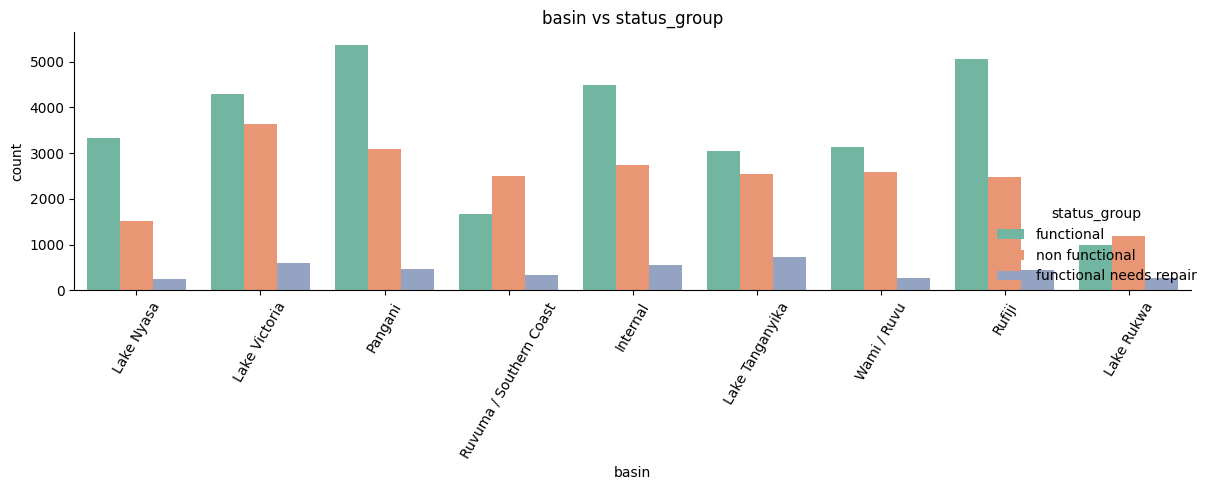

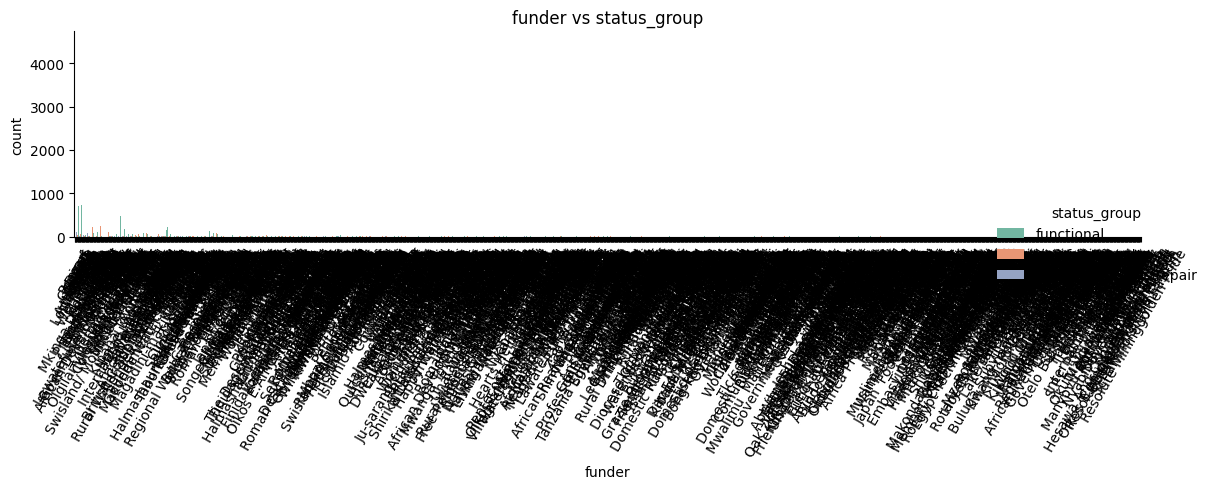

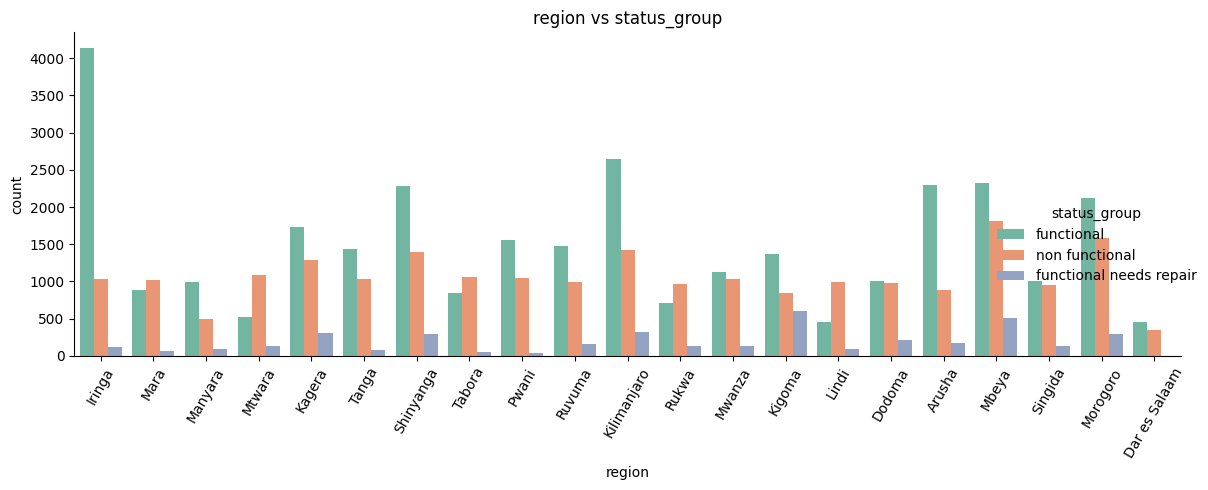

In [16]:
# Load cleaned data
df = pd.read_csv(os.path.join(data_path, 'cleaned_data_filled_V6.csv'))

# Fill missing categorical values with 'Unknown'
categorical_cols = df.select_dtypes(include='object').columns
missing_cat = df[categorical_cols].isnull().sum()
print('missing categorical values:')
print(missing_cat)
df[categorical_cols] =df[categorical_cols].fillna('Unknown')

# Selected categorical variable 
catvars = [
    'region','quantity','management','water_quality',
    'quantity','payment','source','basin', 'funder','region'
    
]


# Plot grouped bar plots colored by pump status
target = 'status_group'
for col in catvars:
    sns.catplot(x=col, kind='count', hue=target, data=df, height=5, aspect=2, palette='Set2')
    plt.xticks(rotation=60)
    plt.title(f"{col} vs {target}")
    plt.tight_layout()
    plt.show()

### Encoding for modeling prep

In [17]:

from sklearn.preprocessing import LabelEncoder

#  Drop high-cardinality columns
drop_cols = ['funder', 'installer', 'wpt_name', 'subvillage', 'scheme_name']
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in drop_cols and col != 'id' and col != target]

# One-hot encode medium-cardinality features (between 3 and 10 unique values)
onehot_cols = [col for col in categorical_cols if 2 < df[col].nunique() <= 10]
df_encoded = pd.get_dummies(df, columns=onehot_cols, drop_first=True)

#  Label encode low-cardinality features (<= 2 unique values)
label_enc_cols = [col for col in categorical_cols if df[col].nunique() <= 2]
label_encoders = {}
for col in label_enc_cols:
    le = LabelEncoder()
    df_encoded[col] = df_encoded[col].astype(str)
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

#  Save encoded dataset
df_encoded.to_csv(os.path.join(out_path, 'encoded_data_V1.csv'), index=False)

print("Categorical EDA and encoding complete.")


Categorical EDA and encoding complete.


In [18]:
# Load data
y = pd.read_csv(os.path.join(data_path, 'train_labels.csv'))
x_full = pd.read_csv(os.path.join(data_path, 'cleaned_data_filled_V6.csv'))
x_full = x_full.drop(columns=['status_group'], errors='ignore')

# Drop status_group if present
x_full = x_full.drop(columns=['status_group'], errors='ignore')
df = pd.merge(y, x_full, on='id', how='inner')

from sklearn.preprocessing import StandardScaler

#  Choose  features
features = ['amount_tsh_capped', 'gps_height', 'population', 'construction_year', 'num_private']
x = df[features].copy()

# Apply standard scaling (mean 0, std 1)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

#  Convert back to DataFrame (to keep column names)
x = pd.DataFrame(x_scaled, columns=features)

#  Prepare target
y = df['status_group'].astype('category').cat.codes


# Shape check
print("X shape:", x.shape)
print("Y shape:", y.shape)



X shape: (57588, 5)
Y shape: (57588,)


In [19]:
import statsmodels.api as sm
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
print(results.summary2())


                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.060      
Dependent Variable: y                AIC:                154206.6858
Date:               2025-05-05 20:19 BIC:                154260.4522
No. Observations:   57588            Log-Likelihood:     -77097.    
Df Model:           5                F-statistic:        740.7      
Df Residuals:       57582            Prob (F-statistic): 0.00       
R-squared:          0.060            Scale:              0.85195    
--------------------------------------------------------------------
                     Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------
const                0.8416   0.0038 218.8126 0.0000  0.8341  0.8492
amount_tsh_capped   -0.1094   0.0039 -28.4024 0.0000 -0.1170 -0.1019
gps_height          -0.0889   0.0039 -22.8757 0.0000 -0.0965 -0.0812
population          -0.0264   0.0039  -6.8129 0.0000 

We see that the basic regression considers all the quantitative variables statistically significant, but not having such a large effect, with the exception of construction year. This suggests that the analysis will rely on 